In [71]:
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn

In [72]:
class Interpolator1D(nn.Module):
    times: jnp.ndarray
    values: jnp.ndarray
    method: str

    def setup(self):
        pass 

    def __call__(self, t_evaluation, deg=None):
        if self.method == "linear":
            return self._linear_interpolate(t_evaluation)
        elif self.method == "cubic-poly":
            if deg is None:
                raise ValueError("Degree (deg) must be specified for cubic-polynomial interpolation.")
            return self._polynomial_interpolate(t_evaluation, deg)
        else:
            raise ValueError(f"Interpolation method '{self.method}' is not supported.")
    
    def _linear_interpolate(self, t_evaluation):
        idx = jnp.searchsorted(self.times, t_evaluation) - 1
        idx = jnp.clip(idx, 0, len(self.times) - 2)
        x0 = self.times[idx]
        x1 = self.times[idx + 1]
        y0 = self.values[idx]
        y1 = self.values[idx + 1]
        return y0 + (y1 - y0) * (t_evaluation - x0) / (x1 - x0)

In [73]:
class Integrator(nn.Module):
    strategy: str
    method: str
    interp: nn.Module 

    def setup(self):
        pass
    
    def __call__(self, fun, t_evaluation, y0):
        if self.strategy == 'fixed-grid':
            return self.fixed_grid(fun, t_evaluation, y0)
        elif self.strategy == 'adaptive':
            return self.adaptive(fun, t_evaluation, y0)
        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")
    
    def fixed_grid(self, fun, t_evaluation, y0):
        """
        Perform numerical integration using fixed grid.
        """
        delta_ts = jnp.diff(t_evaluation)
        y = jnp.zeros_like(t_evaluation)
        y = y.at[0].set(y0)
        
        for en, (dt, t) in enumerate(zip(delta_ts, t_evaluation[:-1])):  # Exclude the last time step for iteration
            dy = self.step(fun, dt, t)
            y = y.at[en + 1].set(y[en] + dy)
        
        return (t_evaluation, y)

    def step(self, fun, dt, t):

        if self.method == 'euler':
            u = self.interp(t)
            dy = fun(u) * dt 
            return dy

In [76]:
import matplotlib.pyplot as plt

def u_function(t): 
        return jnp.sin(t)  

def output(t, y0):
    return 0.5 * jnp.cos(t) + 0.5

# Generate discrete time points, corresponding u values and output values
t_values = jnp.linspace(0, 5, 1000)
u_values = u_function(t_values)
out_values = output(t_values, 1.0)

# We basically want to learn the hidden derivative! i.e. how "output" values evolve w.r.t. to t and, actually, since we know this is the relevant variable, 
# w.r.t. another time series / function /measure "u". In our case we are interested in the quantity below

def derivative(u):
    return -0.5 * u

class approx_derivative(nn.Module):
     
     def setup(self):
          self.layers = [nn.Dense(3, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.constant(-0.3)), 
                         nn.Dense(1, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.constant(-0.3))]
          
          print("In setup!")

     def __call__(self, u):
        u = jnp.expand_dims(u, axis=0)
        out = u
        for layer in self.layers:
               out = nn.tanh(layer(out))
        out = out.squeeze(axis = 0)
        return out
     
xx = approx_derivative()
print(xx)

approx_derivative()


In [77]:
class NeuralODE(nn.Module):

    f_prime_model: nn.Module
    integ_strat: str
    integ_meth: str 
    interp: nn.module

    def setup(self):

        self.integrator = Integrator(strategy=self.integ_strat, method=self.integ_meth, interp=self.interp)

    def __call__(self, times, iv):
    
        t_evaluation, out = self.integrator(self.f_prime_model, t_evaluation=times, y0=iv)

        return t_evaluation, out

In setup!
In setup!
In setup!


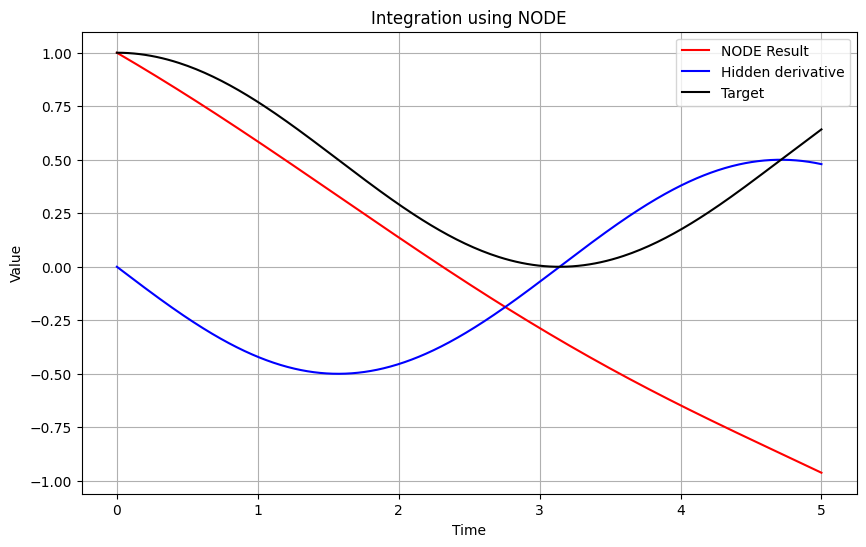

Epoch 0, Loss: 0.4688
In setup!
Epoch 1, Loss: 0.3815
In setup!
Epoch 2, Loss: 0.3035
In setup!
Epoch 3, Loss: 0.2361
In setup!
Epoch 4, Loss: 0.1807
In setup!
In setup!


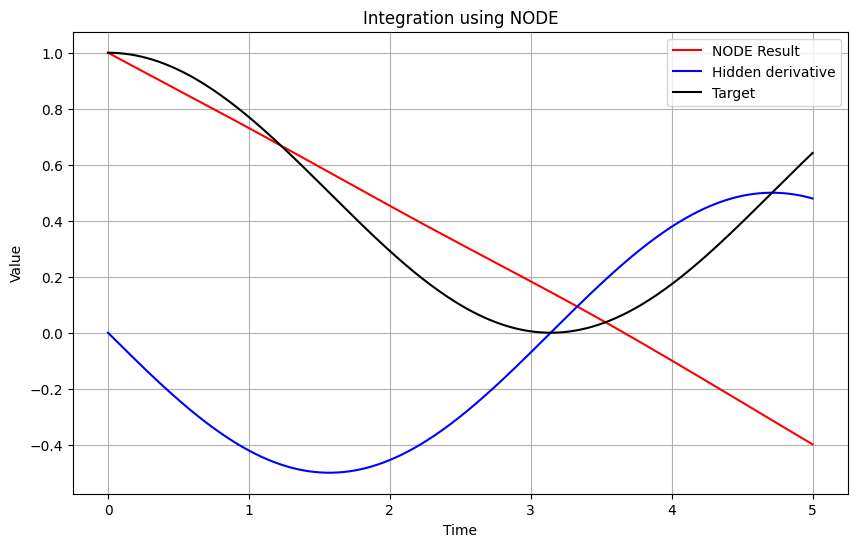

Epoch 5, Loss: 0.1383
In setup!
Epoch 6, Loss: 0.1094
In setup!
Epoch 7, Loss: 0.0936
In setup!
Epoch 8, Loss: 0.0893
In setup!
Epoch 9, Loss: 0.0936
In setup!
In setup!


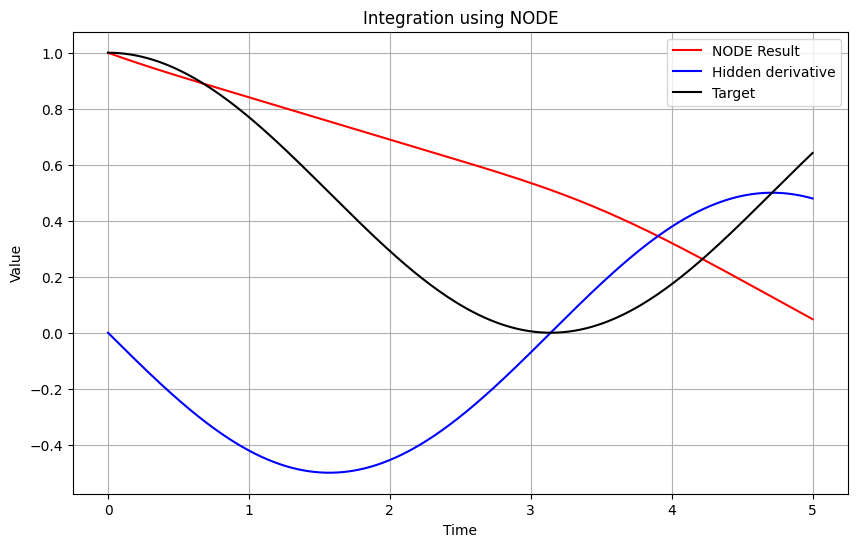

Epoch 10, Loss: 0.1029
In setup!
Epoch 11, Loss: 0.1134
In setup!
Epoch 12, Loss: 0.1220
In setup!
Epoch 13, Loss: 0.1266
In setup!
Epoch 14, Loss: 0.1266
In setup!
In setup!


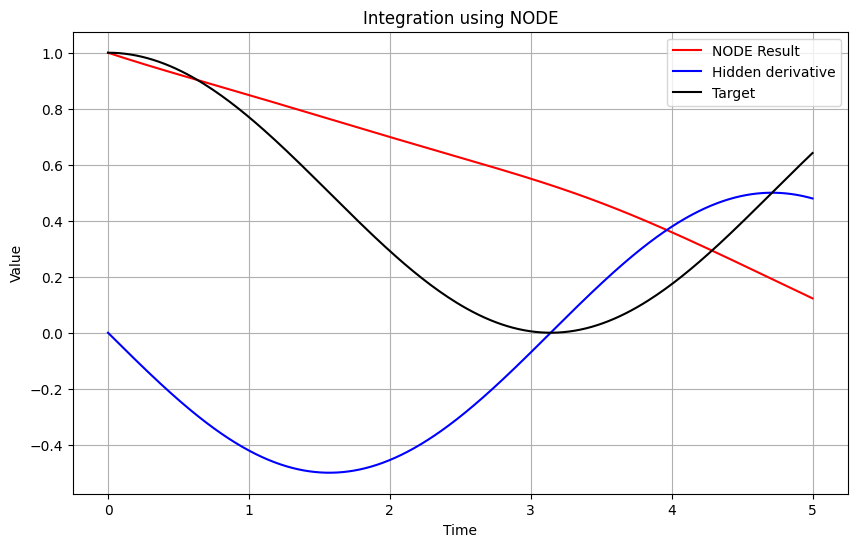

Epoch 15, Loss: 0.1225
In setup!
Epoch 16, Loss: 0.1152
In setup!
Epoch 17, Loss: 0.1060
In setup!
Epoch 18, Loss: 0.0964
In setup!
Epoch 19, Loss: 0.0875
In setup!
In setup!


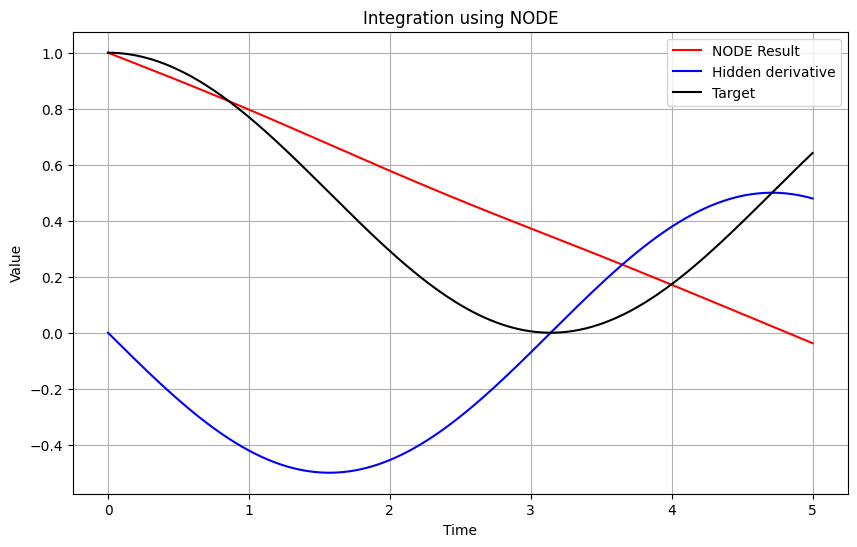

Epoch 20, Loss: 0.0801
In setup!
Epoch 21, Loss: 0.0745
In setup!
Epoch 22, Loss: 0.0710
In setup!
Epoch 23, Loss: 0.0693
In setup!
Epoch 24, Loss: 0.0690
In setup!
In setup!


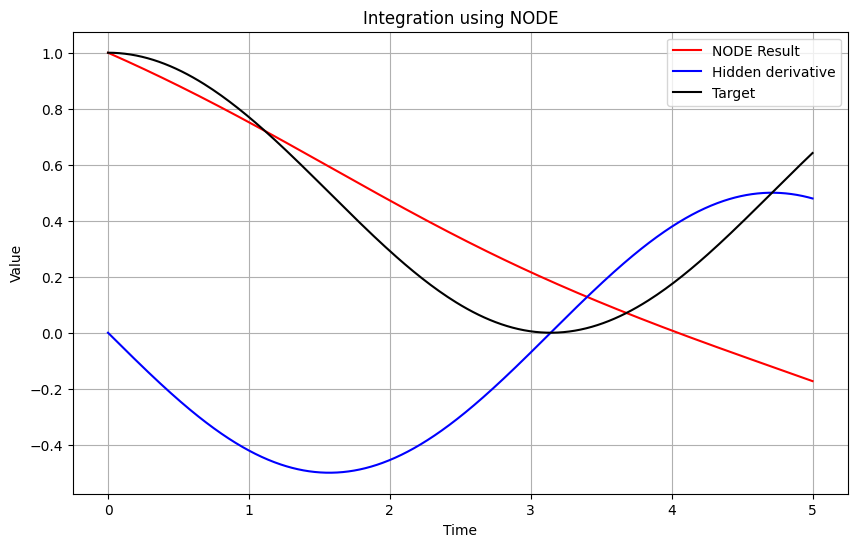

Epoch 25, Loss: 0.0695
In setup!
Epoch 26, Loss: 0.0703
In setup!
Epoch 27, Loss: 0.0709
In setup!
Epoch 28, Loss: 0.0709
In setup!
Epoch 29, Loss: 0.0702
In setup!
In setup!


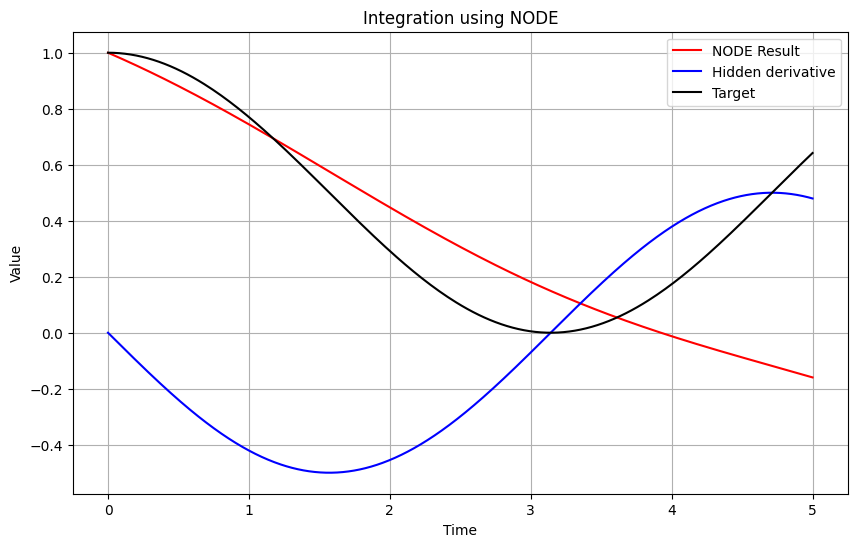

Epoch 30, Loss: 0.0687
In setup!
Epoch 31, Loss: 0.0665
In setup!
Epoch 32, Loss: 0.0638
In setup!
Epoch 33, Loss: 0.0610
In setup!
Epoch 34, Loss: 0.0581
In setup!
In setup!


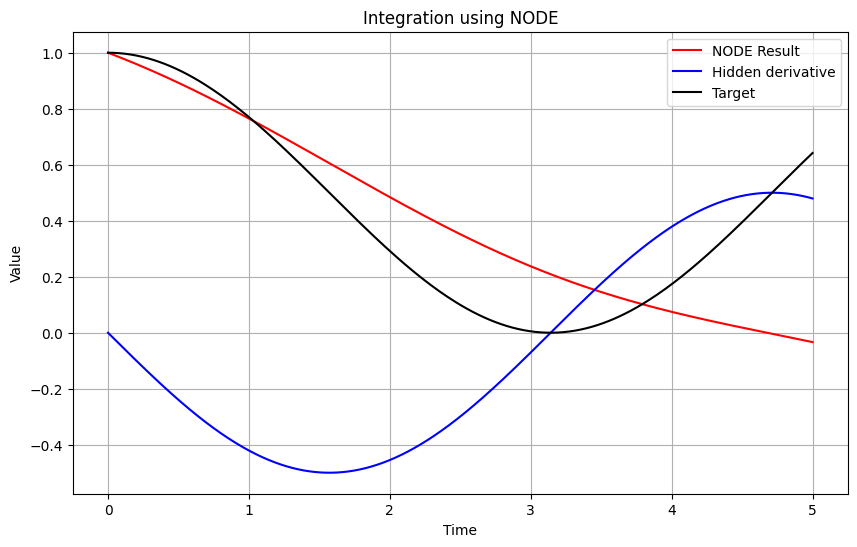

Epoch 35, Loss: 0.0554
In setup!
Epoch 36, Loss: 0.0531
In setup!
Epoch 37, Loss: 0.0513
In setup!
Epoch 38, Loss: 0.0499
In setup!
Epoch 39, Loss: 0.0489
In setup!
In setup!


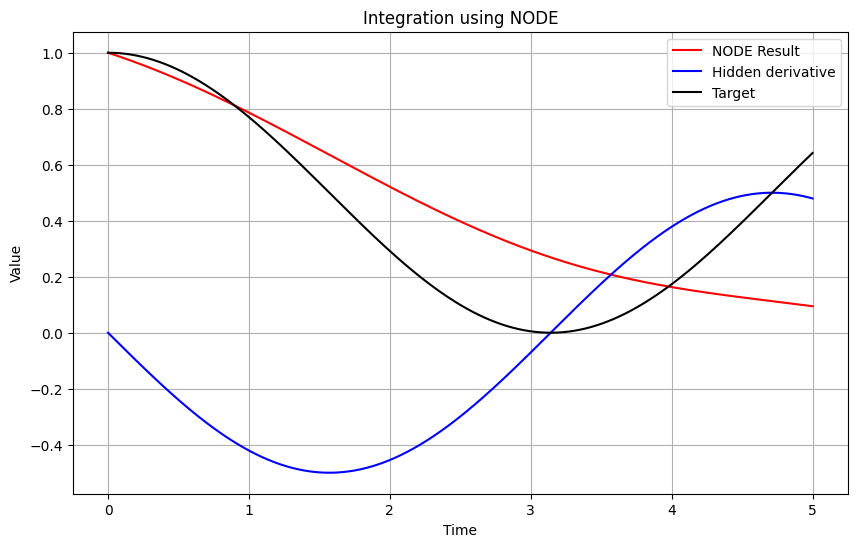

Epoch 40, Loss: 0.0482
In setup!
Epoch 41, Loss: 0.0476
In setup!
Epoch 42, Loss: 0.0469
In setup!
Epoch 43, Loss: 0.0461
In setup!
Epoch 44, Loss: 0.0451
In setup!
In setup!


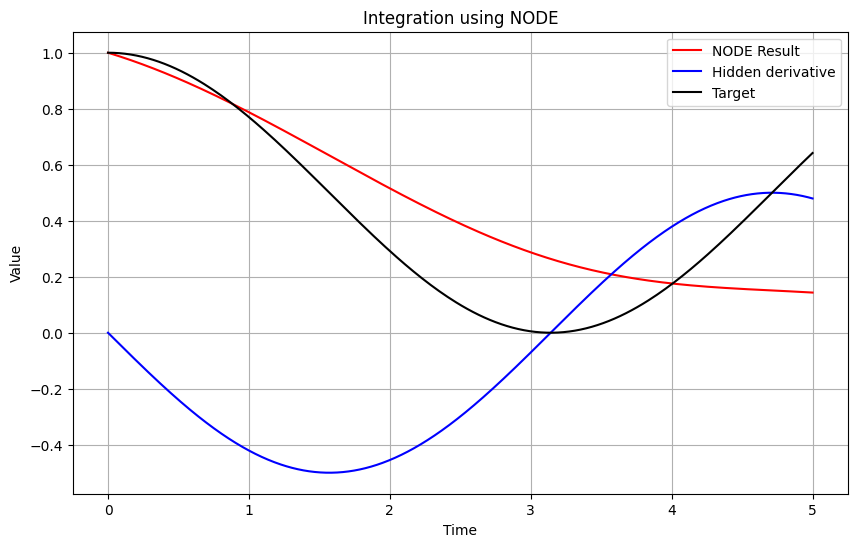

Epoch 45, Loss: 0.0439
In setup!


KeyboardInterrupt: 

In [79]:
from flax.training import train_state
import optax

# Since our integrator might need to call the target parametrized function "derivative" multiple times points t, we first create an interpolator of u w.r.t. t
interp = Interpolator1D(t_values, u_values, method='linear')

# Inference Data
y0 = jnp.array(1.0)
t_evaluation = jnp.linspace(0, 5, 250)


# Initialize the model
deriv_model = approx_derivative()
model = NeuralODE(deriv_model, 'fixed-grid', 'euler', interp)


params = model.init(jax.random.PRNGKey(0), jnp.ones_like(t_evaluation), jnp.array(1.0))['params']
optimizer = optax.adam(learning_rate=1e-2)
state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimizer
)




epochs = 300

for epoch in range(epochs):

    def loss_fn(params):
        t_evals, pred_values = model.apply({'params': params}, t_evaluation, y0)
        return jnp.mean((pred_values - output(t_evaluation, y0)) ** 2)

    grad_fn = jax.value_and_grad(loss_fn)
    loss_val, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    
    if (epoch) % 5 == 0:
        # Compute analytical solution
        analytical_results = output(t_evaluation, y0)

        fun_values = derivative(u_values)

        ts, node_result = model.apply({'params': state.params}, t_evaluation, y0)

        # Plot the results
        plt.figure(figsize=(10, 6))
        plt.plot(t_evaluation, node_result, label='NODE Result', color='red')
        plt.plot(t_values, fun_values, label='Hidden derivative', color='blue', linestyle='-')
        #plt.plot(t_evaluated, result, label='Numerical Solution', color='red', linestyle='--')
        plt.plot(t_evaluation, analytical_results, label='Target', color='black')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Integration using NODE')
        plt.grid(True)
        plt.legend()
        plt.show()


   
    print(f'Epoch {epoch}, Loss: {loss_val:.4f}')

In [88]:
import os
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import flax.linen as nn
#from flax.core import FreezeDict
import jax.nn as jnn
import jax.numpy as jnp

from modules.utils import choose_nonlinearity

class mlp(nn.Module):
    input_sizes: list
    nonlinearity: str
    time_dependency: str
    time_sizes: list
    initializer: str

    def setup(self):

        # Initializers
        if self.initializer[0] == 1:
            dense_init = nn.initializers.xavier_uniform()

        elif self.initializer[0] == 2:
            dense_init = nn.initializers.orthogonal(2)

        elif self.initializer[0] == 0:
            dense_init = nn.initializers.zeros_init()
        
        bias_init = nn.initializers.constant(self.initializer[1])

        # Define Layers from input_sizes
        self.layers = [nn.Dense(o, kernel_init=dense_init, bias_init=bias_init) for o in self.input_sizes[1:]]
        
        # Nonlinearity of choice
        self.nonlinearity_fn = choose_nonlinearity(self.nonlinearity)


    def __call__(self, x):
        
        #time = x[:, 0, :]
        #x = x[:, 1, :]
        
        # Apply transformation to u values
        for layer in self.layers[:-1]:
            x = nn.tanh(layer(x))
        out = self.layers[-1](x)
        
        return out

 


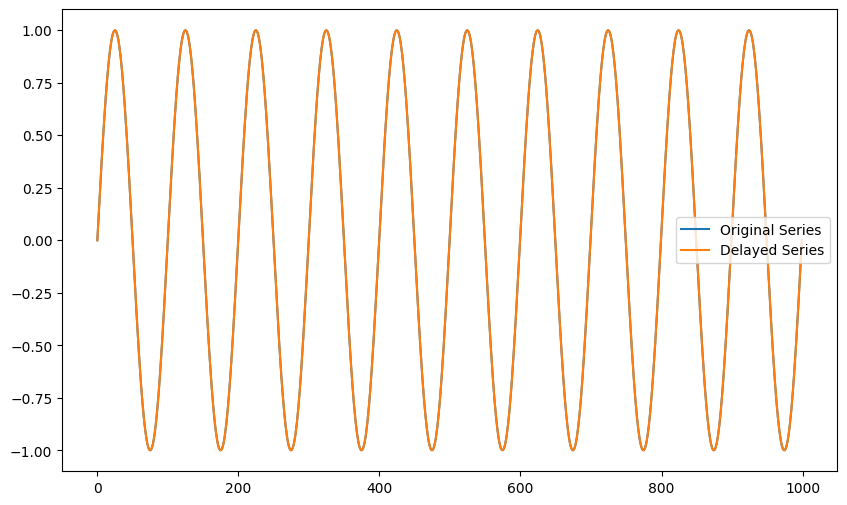

In [89]:
def generate_simple_data(seq_length=1000, delay=0):
    t = jnp.linspace(0, 20 * jnp.pi, seq_length)
    original_series = jnp.sin(t)
    delayed_series = jnp.roll(original_series, delay)
    return original_series, delayed_series

# Generate the data
seq_length = 1000
original_series, delayed_series = generate_simple_data(seq_length)

# Plot the generated data
plt.figure(figsize=(10, 6))
plt.plot(original_series, label='Original Series')
plt.plot(delayed_series, label='Delayed Series')
plt.legend()
plt.show()

def create_dataset(original_series, delayed_series, input_size):
    X = jnp.stack([original_series[i:i+input_size] for i in range(len(original_series) - input_size)], axis=0)
    y = delayed_series[input_size:]
    return X, y

input_size = 10
X, y = create_dataset(original_series, delayed_series, input_size)

# Split the data into training and test sets
train_size = int(0.8 * X.shape[0])
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


Epoch 0, Loss: 0.3566


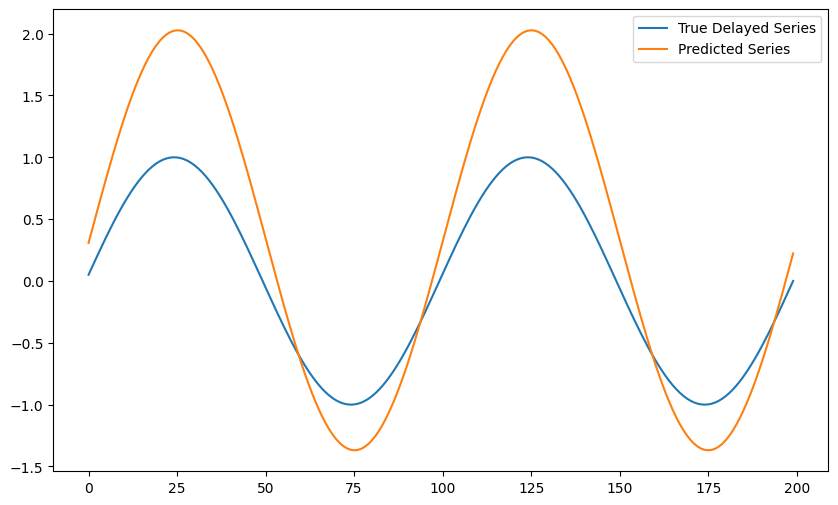

Epoch 250, Loss: 0.1289


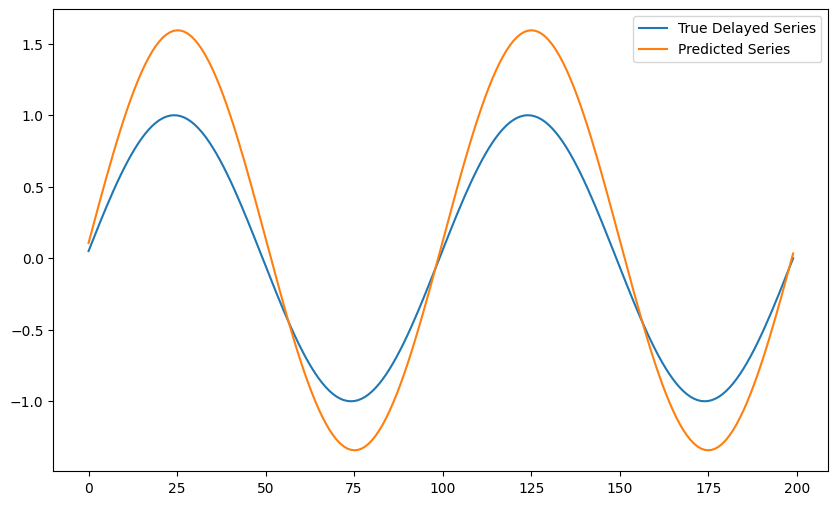

Epoch 500, Loss: 0.0451


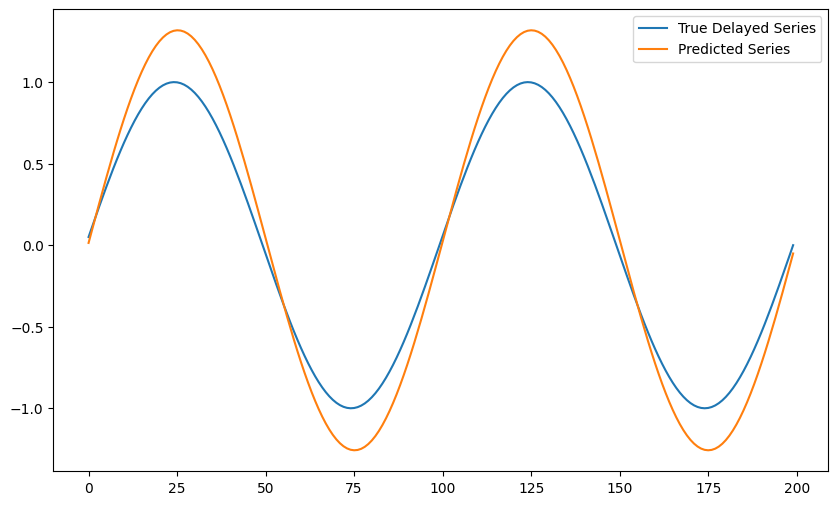

Epoch 750, Loss: 0.0149


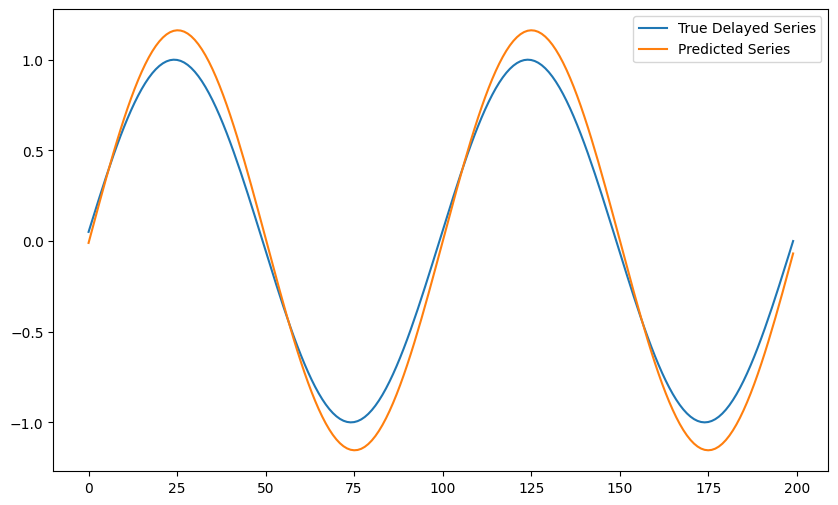

Epoch 1000, Loss: 0.0050


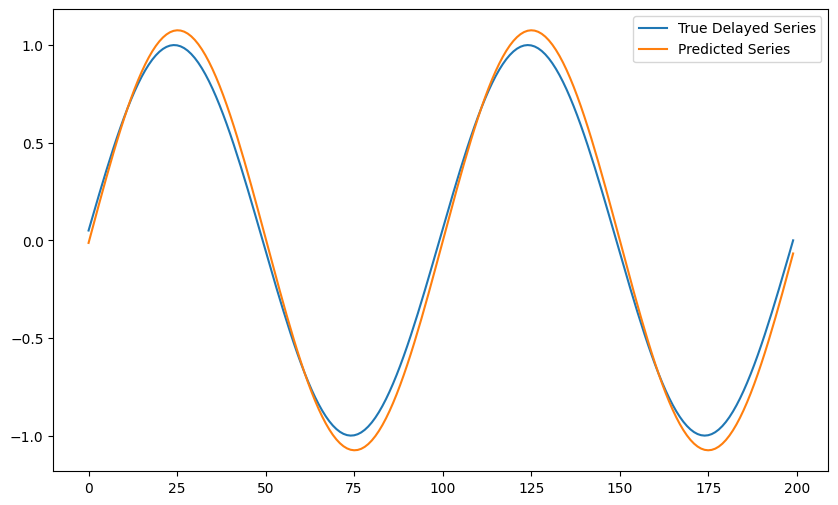

KeyboardInterrupt: 

In [98]:

from jax import random, jit, grad, value_and_grad


input_size = 1
X, y = create_dataset(original_series, delayed_series, input_size)

# Split the data into training and test sets
train_size = int(0.8 * X.shape[0])
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize the model
model = mlp(input_sizes=[input_size, 1], nonlinearity='tanh', initializer=(1, 0.33), time_dependency='none', time_sizes=[])

# Initialize the parameters
key = random.PRNGKey(0)
params = model.init(key, X_train)
tx = optax.adam(0.001)     # Create the optimizer
state = train_state.TrainState.create(
    apply_fn=model.apply, 
    params=params, 
    tx=tx)

# Training loop
for epoch in range(3000):  # Reduced epochs for quick experimentation

    # Define the loss function
    def loss_fn(params):
        preds = model.apply(params, X_train)
        preds = preds.squeeze(-1)
        residuals = preds - y_train
        loss = jnp.mean(residuals ** 2)
        #print(f"Preds: {preds[:5]}")
        #print(f"Targets: {y_train[:5]}")
        #print(f"Residuals: {residuals[:5]}")
        #print(f"Loss: {loss:.4f}")
        return loss

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)

    
    
    if epoch % 250 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')
        # Make predictions
        preds = state.apply_fn(state.params, X_test)


        # Plot results
        plt.figure(figsize=(10, 6))
        plt.plot(y_test, label='True Delayed Series')
        plt.plot(preds, label='Predicted Series')
        plt.legend()
        plt.show()

